<a href="https://colab.research.google.com/github/GilliesK/Deleuze-bank/blob/master/Stochastic_Simulation_Algorithm_Time_Varying.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Vector of Times
t = np.linspace(0, 100, 101) 


k_m = 10
g_m = 1

a = 1
b = 2 
c = 30

# Vector of Initial Conditions (OFF,ON,R)
X = np.array([0], dtype=int)   # OFF = X[0], ON = X[1], R = X[2]  

# Stoichiometry Matrix -- must be transposed (flipped) 
# Species:    OFF,ON,mRNA

S = np.array([[1],
              [-1] 
              ])


# Propensity Functions (anonymous function)
WB = lambda X,t: np.array([[k_m],  
              [g_m*X[0] / (a+b*(t>c))]]).T        


# Propensity Functions (anonymous function)
WA = lambda X,t: np.array([[k_m*(a+b*(t>c))],  
              [g_m*X[0]]]).T   

In [2]:

# Function to randomly determine next time and next state using random number generation
# based on the current propensities (exponential waiting time)
def next_jump(W,t,X):
  current_propensities = W(X,t)
  mod_prop = np.zeros((1,current_propensities.shape[1]+1))
  mod_prop[0,1:] = current_propensities
  mod_prop[0,0] = np.max(current_propensities)
  current_propensities = mod_prop
  total_reactions =current_propensities.shape[1]  # Get total number of reactions
  
  # Update time of next reaction (where tau = 1/w0*log(1/rand)
  time_next_rxn = -np.log(np.random.rand()) / np.sum(current_propensities)

  # Generate random number to select the new reaction to happen based on current state
  random_rate = np.random.rand() * np.sum(current_propensities)

  # Select the new reaction to happen based on current state
  cumulative_prop = np.cumsum(current_propensities)
  for i in range(total_reactions):
    if cumulative_prop[i] >= random_rate:
      rxn_id = i
      break
  return time_next_rxn,rxn_id  ##Return these back out

def SSA_traj(S, W, x0, time_vector):
    total_states = S.shape[0]     # Get total states (number of species)
    # now, make a null reaction and append it to the stoich matrix
    S = np.vstack([np.zeros(S.shape[1]), S])
    x = x0  # Set the state to initial state
    t = time_vector[0]  # Initial time - 1st time in time_vector
    tstop = time_vector[-1]  # Stop time - Last time in time_vector
    record_index = 0  # Initialize counter
    Nt = len(time_vector)  # Total number of time points
    traj_data = np.zeros((total_states, Nt)) # Preallocate for efficiency

    while t < tstop:  # While time is less than last time point
  
        time_next_rxn,rxn_id = next_jump(W,t,x)  # Run function to get next time and next reaction
        t += time_next_rxn

        while t >= time_vector[record_index]:  # If time passed the record vector, record the state
            traj_data[:, record_index] = x
            record_index += 1   # Update the counter
            if time_vector[record_index] == tstop:  # If counter has moved past the final time point, end and return the data
                traj_data[:, record_index] = x
                return traj_data

        x = x + S[rxn_id, :]  # Update the state based on last reaction


In [3]:
traj_data = SSA_traj(S, WA, X, t)

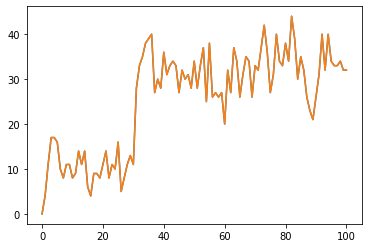

In [4]:
f,ax = plt.subplots()

ax.plot(traj_data.T)